In [1]:
# import necessary modules
# for running/displaying the ABM
import math
import random
from mesa import Agent
from mesa import Model
from mesa.time import SimultaneousActivation
from mesa.time import RandomActivation
from mesa.space import MultiGrid
from mesa.visualization.modules import CanvasGrid
from mesa.visualization.ModularVisualization import ModularServer
from mesa.visualization.UserParam import UserSettableParameter
# for data collection/plotting/saving
import numpy as np
import matplotlib.pyplot as plt
import pickle

In [2]:
# define distance calculation function that needs to be call mid-decision in agent operation
def get_distance(pos_1, pos_2):
    """ 
    Get the distance between two points
    
    Args:
        pos_1, pos_2: Coordinate tuples for both points
    """
    x1, y1 = pos_1
    x2, y2 = pos_2
    dx = x1 - x2
    dy = y1 - y2
    return math.sqrt( dx**2 + dy**2 )

# Create Agent Classes

In [3]:
# adapted from sugarscape_cg
"""
For the following agent classes:

Args:
    unique_id: a unique value to distinguish the agent
    pos: where the agent is located, as grid coordinates
    model: standard model reference for agent
"""
class Environment(Agent):
    def __init__(self, unique_id, pos, model):
        super().__init__(unique_id, model)
        self.pos = pos

class ForageArea(Agent):
    def __int__(self, unique_id, pos, model):
        super().__init__(unique_id, model)
        self.pos = pos

class DropArea(Agent):
    def __int__(self, unique_id, pos, model):
        super().__init__(unique_id, model)
        self.pos = pos

class Tree(Agent):
    def __int__(self, unique_id, pos, model):
        super().__init__(unique_id, model)
        self.pos = pos
        
class CacheArea(Agent):
    def __int__(self, unique_id, pos, model):
        super().__init__(unique_id, model)
        self.pos = pos
        
class NestArea(Agent):
    def __int__(self, unique_id, pos, model):
        super().__init__(unique_id, model)
        self.pos = pos        

class Nest(Agent):
    """
    The nest of the ants, destination for cut leaves
    
    Functions:
        add(self, amount): increments the food quantity the ant colony has harvested
    """
    def __init__(self, unique_id, pos, model):
        """
        Records the unique_id with the super function
        Saves the position
        Initializes the food counters to 0
        """
        super().__init__(unique_id, model)
        self.pos = pos
        self.amount = 0

class Foraged_Food(Agent):
    """
    A food item for the ants, generated in the foraging area
    
    Functions:
        add(self, amount): food is added to the agent, i.e. appears in foraging area
        remove(self): food is removed from the agent, i.e. picked up from foraging area
        any_food(self): returns bool to show if agent contains food, called when ants are foraging
    """
    def __init__(self, unique_id, model):
        """
        Records the unique_id with the super function
        """
        super().__init__(unique_id, model)

    def remove(self):
        """
        Removes the agent from simulation
        """
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)
    
class Dropped_Food(Agent):
    """
    A food item for the ants, appears in the cache when ants drop a foraged food in the drop area
    
    Functions:
        add(self, amount): food is added to the agent, i.e. appears in cache
        remove(self): food is removed from the agent, i.e. picked up from cache
        any_food(self): returns bool to show if agent contains food, called when ants are foraging
    """
    def __init__(self, unique_id, model):
        """
        Records the unique_id with the super function
        """
        super().__init__(unique_id, model)

    def remove(self):
        """
        Removes the agent from simulation
        """
        self.model.grid.remove_agent(self)
        self.model.schedule.remove(self)

In [4]:
class Ant(Agent):
    """
    Free agent in model, moves/takes actions based on nearby environment
    Ants wander along an existing pheromone trail until food is within vision range ('foraging')
        If the ant decides to pick up, it will efficiently walk towards nearest food in vision range
        If not, the ant will continue following the pheromone trail
    When ant is in the same cell as food, it will pick up and start carrying the food
    When carrying the food, ant will efficiently walk towards nest ('homing')
    When at the dropzone, ant will decide whether or not to drop food
        If dropped, ant will stop carrying food, which reappears as food item in the cache
        If not dropped, ant will continue walking towards nest down the tree
    When ant is at the nest, ant will store the food, incrementing the score counter
    
    Functions:
        get_item(self, item): looks for a specified item (agent) in the ant's current cell
        step(self): runs decision tree for each ant at each model step
        forage(self): ant looks for nearby food
        pickup_or_phero(self, food): ant decides whether or not to pick up food
        food_move(self, food): ant walks towards food
        walk_here(self, destination): ant walks towards a specified location on the grid
        phero_trail(self): ant walks up or down the pheromone trail without food
        homing_or_drop(self): ant is carrying the food, decides whether to drop it or walk to nest
        food_drop(self): ant drops food at the top of the tree
    """
    def __init__(self, unique_id, nest_loc, treetop_loc, model):
        """
        Records the unique_id with the super function
        
        Initializes the ant to the foraging / undecided pickup states & upwards movement direction
            - FORAGING state: ant is looking for food
            - HOMING state: ant is moving towards the nest
                - HOMING_forager: ant has found its food in the foraging area 
                - HOMING_collector: ant has found its food in the cache
            
            - foraged or dropped food pickup states
                - UNDECIDED: ant has not recently found any foraged/dropped food
                - YES: ant has seen a foraged/dropped food + decided to pick it up
                - NO: ant has seen a foraged/dropped food + decided to not pick it up
            
            - UP direction: ant is moving along the pheromone trail up the tree
            - DOWN direction: ant is moving along the pheromone trail down the tree
        
        Saves the nest + treetop locations to establish pheromone trail endpoints
        Initializes the food_carry quantity to 0
        """
        super().__init__(unique_id, model)
        self.state = "FORAGING"
        self.direction = "UP"
        self.foraged_food_pickup_state = "UNDECIDED"
        self.dropped_food_pickup_state = "UNDECIDED"
        self.nest_loc = nest_loc
        self.treetop_loc = treetop_loc
        self.food_carry = 0
        
    # adapted from Sugarscape get_sugar()
    def get_item(self, item):
        """
        Looks for a specified item (agent) in the ant's current cell
        Returns full agent class
        
        Args:
            item: specifies which type of agent to look for
        """
        # returns all agents in the ant's cell
        this_cell = self.model.grid.get_cell_list_contents([self.pos])
        for agent in this_cell:
            if type(agent) is item:
                return agent

    def step(self):
        """
        Steps each ant agent forward 1 simulation time unit:
            - Logs the y-coordinate of the ant
            - Walks through decision hierarchy based on:
                - the ant's internal states
                - the colony's behavioral parameters
                - observation of the surrounding environment
            - Ant moves 1 cell within its Moore neighborhood
        
        Ants will either be FORAGING for food or HOMING in on the nest location
            If a FORAGING ant finds food + has decided to pick it up, 
                they pick the food up + begin HOMING / walking DOWN
            Else, they search for food via forage()
            
            If a HOMING agent is at the nest,
                they store the food + return to FORAGING / walking UP
            Else, they walk towards the nest via homing_or_drop()
        
        Distinguishes between foraged + dropped/collected food
             - different decision/action trees
             - different record logs
        """
        # log the y-coordinate of the ant
        self.model.ant_pos_step.append((self.unique_id,self.pos[1]))
        
        # start of each simulation time step for each ant
        if self.state == "FORAGING":
            # look for food in the ant's cell
            foraged_food = self.get_item(Foraged_Food)
            dropped_food = self.get_item(Dropped_Food)
            
            # three checks:
                # if a foraged/drop food agent exists in the ant's cell
                # if there still exists a food quantity in the food agent
                    # food agent with 0 food exists when another ant has picked up that food item
                    # during that step, where the agent has yet to be removed from the grid
                # if the ant has decided to pickup that food (passed forage() + pickup_or_phero())
            if foraged_food is not None and self.foraged_food_pickup_state == "YES":
                # ant picks up food
                self.food_carry += 1
                # empty food agent is flagged for removal from the grid
                foraged_food.remove()
                # replaces foraged food agent in the current location
                new_food = Foraged_Food(self.model.next_id(), self.model)
                self.model.grid.place_agent(new_food, self.pos)
                self.model.schedule.add(new_food)
                # switches homing/foraging states
                self.state = "HOMING_forager"
                # ant switches pheromone trail travel direction
                self.direction = "DOWN"
                # restores pickup decision states
                self.foraged_food_pickup_state = "UNDECIDED"
                self.dropped_food_pickup_state = "UNDECIDED" # line not included in "no reset"
                
            # similar changes to picking up foraged food, but a food item is not replaced
            elif dropped_food is not None and self.dropped_food_pickup_state == "YES":
                self.food_carry += 1
                dropped_food.remove()
                self.state = "HOMING_collector"
                self.direction = "DOWN"
                self.foraged_food_pickup_state = "UNDECIDED" # line not included in "no reset"
                self.dropped_food_pickup_state = "UNDECIDED"
                
            # food was not found, ant looks for nearby food
            else: self.forage()
        
        else: # state: HOMING as either collector or forager
            # if at nest, ant drops food + switches states
            # food is logged at the nest for display reasons + in a model list as its respective type
            if self.pos == self.nest_loc:
                self.food_carry -= 1
                self.get_item(Nest).amount += 1
                if self.state == "HOMING_collector":
                    self.model.amount_collector += 1
                elif self.state == "HOMING_forager": # carried its food from the foraging area
                    self.model.amount_generalist += 1
                self.state = "FORAGING"
                self.direction = "UP"
                    
            # ant is not at nest, ant walks home or drops food at drop area
            else: self.homing_or_drop()
    
    # adapted from wolf_sheep RandomWalker
    def forage(self):
        """
        Foraging ant looks for food within its vision range
            If food is found, ant decides whether or not to pickup food via pickup_or_phero()
                If both foraged + dropped food is found, ant prioritizes foraged food
            It not, ant follows the pheromone trail via phero_trail()
        """
        # gathers food items from a list of agents within vision range
        nearby_foraged_foods = [
            x for x in self.model.grid.get_neighbors(
                self.pos, moore=True, radius=self.model.vision
            ) if type(x) is Foraged_Food
        ]
        
        nearby_dropped_foods = [
            x for x in self.model.grid.get_neighbors(
                self.pos, moore=True, radius=self.model.vision
            ) if type(x) is Dropped_Food
        ]
        
        # no food is within vision range, ant follows pheromone trail
        if nearby_foraged_foods + nearby_dropped_foods == []:
            self.phero_trail()
            
        elif nearby_foraged_foods == []: # only dropped food(s) exists within vision range
            # generates distances between ant and each food item
            nearby_foods_dist = [get_distance(self.pos, x.pos) for x in nearby_dropped_foods]
            # compiles list of foods closest to the ant, translates to agent list by indexing
            closest_foods = [
                nearby_dropped_foods[index] for index, dist in enumerate(nearby_foods_dist) 
                if dist == min(nearby_foods_dist)
            ]
            # selects a random food among the closest food list
            # ant decides whether to pickup food or to walk the pheromone trail
            self.pickup_or_phero(random.choice(closest_foods))
            
        else: # foraged food(s) exists within vision range
            nearby_foods_dist = [get_distance(self.pos, x.pos) for x in nearby_foraged_foods]
            closest_foods = [
                nearby_foraged_foods[index] for index, dist in enumerate(nearby_foods_dist) 
                if dist == min(nearby_foods_dist)
            ]
            self.pickup_or_phero(random.choice(closest_foods))
            
    def pickup_or_phero(self, food):
        """
        Foraging ant sees food, decides whether or not to pick it up
            A random number is generated:
                If lower than the threshold given at model start, ant walks to it via food_move()
                If not, ant walks up/down phero_trail()
            When either decision is made, ant changes its pickup state to remember decision
            If previously decided, ant bypasses decision
        Decision tree works the same way for foraged/dropped food
        """
        # calls pickup_state + colony_prob related to either foraged or dropped food
        if type(food) is Foraged_Food:
            pickup_state = self.foraged_food_pickup_state
            colony_prob = self.model.colony_forage_prob
            
        else: # type(item): Dropped_Food:
            pickup_state = self.dropped_food_pickup_state
            colony_prob = self.model.colony_pickup_prob
            
        # if the ant has already decided to pickup a foraged_food, walk towards it
        if pickup_state == "YES":
            self.food_move(food)
            
        # if not, walk down tree
        elif pickup_state == "NO":
            self.phero_trail()
            
        else: # pickup_state: UNDECIDED
            # generate a random number to compare with the colony level
            # given this is a number 1-100, the colony number : probability to pickup the food
            if random.randint(1,100) <= colony_prob:
                # if so, ant decides to pickup the food, change state
                if type(food) is Foraged_Food:
                    self.foraged_food_pickup_state = "YES"
                else: # type(item): Dropped_Food:
                    self.dropped_food_pickup_state = "YES"
                # ant walks towards the food
                self.food_move(food)
                
            else: # ant decides to not pickup the food, change state
                if type(food) is Foraged_Food:
                    self.foraged_food_pickup_state = "NO"
                else: # type(item): Dropped_Food:
                    self.dropped_food_pickup_state = "NO"
                # ant walks up/down the pheromone trail
                self.phero_trail()
    
    def food_move(self, food):
        """
        Ant has seen a food within its vision range + has decided to pick it up
        Ant walks directly towards the food
        """
        # generates distances between ant and food item
        distance = get_distance(self.pos, food.pos)
        if distance <= 1.5: 
            # if food is within Moore neighboorhood (diagonal tile distance = sqrt(2)), move to food
            self.model.grid.move_agent(self, food.pos)
        else:
            # if food is outside neighboordhood, ant walks towards food 
            self.walk_here(food.pos)
    
    def walk_here(self, destination):
        """
        Ant walks in an optimal path towards a specified location
            i.e. towards food, end of pheromone trail, nest
        """
        # gathers grid positions of ant's neighbors
        neighbor_pos = [
            n.pos for n in self.model.grid.get_neighbors(self.pos, moore=True) 
            if type(n) is Environment
        ]
        # calculates distances between each neighbor position and destination
        neighbor_dist = [
            get_distance(destination, pos) for pos in neighbor_pos
        ]
        # finds the closest distance to destination, indexes to the position list
        # returns coordinates of closest neighbor
        closest_neighbor_pos = neighbor_pos[
            neighbor_dist.index(
                min(neighbor_dist)
            )
        ]
        # moves agent to the neighbor closest to destination
        self.model.grid.move_agent(self, closest_neighbor_pos)
    
    def phero_trail(self):
        """
        Pheromone trail is pre-existing to simulation start
        Foraging ant hasn't found food or has decided to not pick up, thus will follow phero_trail
        Movement up/down trail is according to random choice among 16 options ~ discrete bell curve
            10 options forward (up/down)         : 62.5% probability ~ 1 sigma 
            2 options to each forward-diagonal   : 12.5% probability ~ 2 sigma
            1 option to each side                : 6.25% probability ~ 3 sigma
        If the ant is walking up the trail + reaches the treetop
            It switches directions + forgets pickup decision made at the bottom
        If the ant is walking down the trail + reaches the cache
            It switches directions + forgets pickup decision made at the top
        """
        
        if self.direction == "UP":
            # once ant reaches treetop, switch directions, forget pickup state at bottom
            if self.pos[1] >= self.treetop_loc[1]: 
                self.direction = "DOWN"
                self.dropped_food_pickup_state = "UNDECIDED"
                
        else: # direction: DOWN
            # once ant reaches cache area, switch directions, forget pickup state at top
            if self.pos[1] <= self.nest_loc[1] + 5: 
                self.direction = "UP"
                self.foraged_food_pickup_state = "UNDECIDED"
        
        # gather the 8 neighbors of ant's cell
        next_moves = self.model.grid.get_neighborhood(self.pos, moore=True)
        
        # gather 3 neighbors in the up/down direction, multiply by 2
        if self.direction == "UP":
            dir_moves = [move for move in next_moves if move[1] > self.pos[1] for i in range(2)]
        else: # direction: DOWN
            dir_moves = [move for move in next_moves if move[1] < self.pos[1] for i in range(2)]

        # gather each up/down + center tile in the dir_moves, multiply by 4 >> 8 in total
        straight_move = [move for move in dir_moves if move[0] == self.pos[0] for i in range(4)]
        # gather 2 neighbors in the side direction
        side_moves = [move for move in next_moves if move[1] == self.pos[1]]
        # add each group to make 10 forward-center moves // 2+2 forward-diagonal moves // 1+1 side moves
        all_moves = dir_moves + straight_move + side_moves
        # randomly choose among this group + move ant to the chosen cell
        next_move = self.random.choice(all_moves)
        self.model.grid.move_agent(self, next_move)
    
    # adapted from Sugarscape
    def homing_or_drop(self):
        """
        Ant is carrying food + moving towards the nest
        
        If ant is at the top of tree (DropArea), it decides whether to drop the food or not
            A random number is generated:
                If lower than the threshold given at model start, food is dropped
                If not, ant continues toward nest
        """
        # find if ant is at the drop area
        current_cell = self.get_item(DropArea)
        
        # generate a random number to compare with the colony level
        # given this is a number 1-100, the colony number : probability to drop the food
        if type(current_cell) is DropArea and random.randint(1,100) <= self.model.colony_drop_prob:
            # if both checks pass, ant drops food
            self.food_drop()
        else: # ant is either not at the drop area or has decided to not drop the food
            # walk straight down until reached the bottom of the pheromone trail (cache area)
            if self.pos[1] > self.nest_loc[1] + 5:
                self.walk_here((self.pos[0], self.nest_loc[1] + 5))
            else: # once reached cache area, walk directly toward nest
                self.walk_here(self.nest_loc)
    
    def food_drop(self):
        """
        Ant drops food at the top of the tree
        Food item is generated at the bottom of the tree
        Ant returns to foraging
        """
        # ant drops the food + returns to foraging
        self.food_carry -= 1
        self.state = "FORAGING"
        
        # generates position for dropped food below ant at cache area
        dropped_loc = ((self.pos[0], self.nest_loc[1] + 5))
        # places dropped food agent
        new_food = Dropped_Food(self.model.next_id(), self.model)
        self.model.grid.place_agent(new_food, dropped_loc) 
        self.model.schedule.add(new_food)
        
        # increments drop counter +1
        self.model.drops += 1

# Create Model

In [5]:
# adapted from ConwaysGameOfLife
class AntWorld(Model):
    """
    AntWorld is a model simulating leaf-cutting ants foraging for food near a 
    food source of variable height with 8 model parameters, 5 fixed for publication:
    
        3 environmental parameters:
            dplen: sets number of grid tiles between the drop + cache areas (1, 10, or 20)
                i.e. how far a food item falls when dropped
            height: vertical extent of grid
                takes dplen + adds forage/nest areas (dplen + fixed @ 15 tiles)
            width: horizontal extent of grid (fixed @ 11 tiles)
        
        5 colony-wide parameters:
            colony_size: how many ants to simulate (fixed @ 25 ants)
            colony_drop_prob: 0-100 threshold, random number generated when ant makes a decision
                whether or not to drop food when the ant reaches the Drop Area (variable)
            colony_pickup_prob: 0-100 threshold, random number generated when ant makes a decision
                whether or not to pickup food the ant finds a dropped_food (variable)
            colony_forage_prob: 0-100 threshold, random number generated when ant makes a decision
                whether or not to pickup food the ant finds a foraged_food (fixed @ 95)
            vision: extent to which an ant can see food (fixed @ 5 cells)
        
        Functions:
            step(): moves model forward 1 time unit, logs relevant data
    """

    def __init__(self, dplen, height, width, colony_size, 
                 colony_drop_prob, colony_pickup_prob, 
                 colony_forage_prob, vision):
        """
        Creates a map with the specified environmental + colony-wide parameters
        
        Initializes each agent by:
            - defining the initial grid position (fixed for food, random for ants)
            - creating a unique ID
            - placing agent on the grid
            - adding agent to the schedule (logs agent states + processes actions)
        
        Starts counters to track step number + drop count + scores + ant positions
        """
        # initializes/starts model run
        super().__init__()
        self.running = True
        
        # schedules all cells to be run randomly, as opposed to simultaneously or in stages
        self.schedule = RandomActivation(self)
#         self.schedule = SimultaneousActivation(self)
        
        # uses a simple 2D grid, where edges do not wrap around
        self.grid = MultiGrid(width, height, torus=False)
        
        # applies specified parameters to model
        self.dplen = dplen
        self.colony_size = colony_size
        self.colony_drop_prob = colony_drop_prob
        self.colony_pickup_prob = colony_pickup_prob
        self.colony_forage_prob = colony_forage_prob
        self.vision = vision
        
        # prints parameters, particularly useful for run iterations
        print("dplen:", self.dplen,
              ", ant_num:", self.colony_size,\
              ", dp:", self.colony_drop_prob,\
              ", dpp:", self.colony_pickup_prob,\
              ", fpp:", self.colony_forage_prob,\
              ", vis:", self.vision)
        
        # starts step counter + drop counter for model run
        self.steps = 0
        self.drops = 0
        self.amount_collector = 0
        self.amount_generalist = 0
        
        ############################################################################################################
        
        # initialize nest agent
        nest_loc = (int(width/2), 2)
        nest = Nest(self.next_id(), nest_loc, self)
        self.grid.place_agent(nest, nest_loc)
        self.schedule.add(nest)
        
        # define the top of the pheromone trail, to be internalized by the ants
        treetop_loc = (int(width/2), nest_loc[1] + vision + self.dplen)
        
        # initialize ant agents randomly throughout grid
        initial_ant_locs = []
        while len(initial_ant_locs) < colony_size:
            ant = Ant(self.next_id(), nest_loc, treetop_loc, self)
            x = random.randint(0,width-1)
            y = random.randint(0,height-1)
            self.grid.place_agent(ant, (x,y))
            self.schedule.add(ant)
            # build initial location list to be sent to tracking list below
            initial_ant_locs.append(nest_loc[1])
        
        # initialize food agents in the top of the foraging area
        for x in range(width):
            for y in range(treetop_loc[1] + vision, treetop_loc[1] + vision + 3):
                food = Foraged_Food(self.next_id(), self)
                self.grid.place_agent(food, (x,y))
                self.schedule.add(food)
        
        # initialize forage area agents
        for x in range(width):
            for y in range(treetop_loc[1] + 1, treetop_loc[1] + vision + 3):
                foragearea_id = ForageArea(self.next_id(), self)
                self.grid.place_agent(foragearea_id, (x,y))
                self.schedule.add(foragearea_id) 
        
        # initialize drop area agents, a single line of cells at the top of the tree
        for x in range(width):
            droparea_id = DropArea(self.next_id(), self)
            self.grid.place_agent(droparea_id, (x, treetop_loc[1]))
            self.schedule.add(droparea_id) 
        
        # initialize tree agents if drop length > 1
        # if dplen = 1, tree does not exist in model + dropped food passes to next cell below
        # if dplen > 1, the vertical length of the tree between cache + drop areas = dplen - 1
        if dplen > 1:
            for x in range(width):
                for y in range(nest_loc[1] + vision + 1, treetop_loc[1]):
                    tree_id = Tree(self.next_id(), self)
                    self.grid.place_agent(tree_id, (x,y))
                    self.schedule.add(tree_id)
        
        # initialize cache area agents, a single line of cells at the bottom of the tree
        for x in range(width):
            cachearea_id = CacheArea(self.next_id(), self)
            self.grid.place_agent(cachearea_id, (x, nest_loc[1] + vision))
            self.schedule.add(cachearea_id)
        
        # initialize nest area agents
        for x in range(width):
            for y in range(0, nest_loc[1] + vision):
                nestarea_id = NestArea(self.next_id(), self)
                self.grid.place_agent(nestarea_id, (x,y))
                self.schedule.add(nestarea_id) 
        
        # initialize environment agents
        for contents,x,y in self.grid.coord_iter():
            enviro_id = Environment(self.next_id(), (x,y), self)
            self.grid.place_agent(enviro_id, (x,y))
            self.schedule.add(enviro_id)
    
    def step(self):
        """
        Steps the model forward 1 simulation time unit
        Logs the step number + y-coordinate of each ant
        """
        # starts/clears position log that tracks the y-coordinate of each ant for the current step
        self.ant_pos_step = []
        # increment step counter
        self.steps += 1
        # steps model forward, each ant moves 1 cell
        self.schedule.step()

# Define Display Parameters

In [6]:
# adapted from sugarscape and schelling
def diffusion_portrayal(agent):
    """
    Defines visualization parameters for each agent
    
    For active agents (Ant, Foraged_Food, Dropped_Food, Nest): 
        - shape: circular
        - layer > 1, thus displayed above background agents
    For background agents (ForageArea, DropArea, Tree, CacheArea): 
        - shape: rectangular
        - layer = 1, thus displayed below active agents
    
    NestArea agents not given display parameters, this area of the grid is left white
    """
    
    # creates dictionary for each agent
    portrayal = {}
    
    if type(agent) is Ant:
        portrayal["Shape"] = "circle"
        portrayal["Filled"] = "true"
        portrayal["r"] = 1
        portrayal["scale"] = 0.9
        portrayal["Color"] = "#0D0D0DBB" # dark gray
        portrayal["Layer"] = 3
        
        # when carrying food:
        if agent.food_carry == 1:
            # ant changes color from dark gray to red 
            portrayal["Color"] = "red"
            # is displayed above non-carrying ants
            portrayal["Layer"] = 4
        
    elif type(agent) is Foraged_Food:
        portrayal["Shape"] = "circle"
        portrayal["r"] = 1
        portrayal["Filled"] = "true"
        portrayal["Layer"] = 3
        portrayal["Color"] = "#00FF00BB" # bright green
    
    elif type(agent) is Dropped_Food:
        portrayal["Shape"] = "circle"
        portrayal["r"] = 1
        portrayal["Filled"] = "true"
        portrayal["Layer"] = 3
        portrayal["Color"] = "purple"
    
    elif type(agent) is Nest:
        portrayal["Shape"] = "circle"
        portrayal["r"] = 2
        portrayal["Filled"] = "true"
        portrayal["Layer"] = 5
        portrayal["Color"] = "#964B00BB"
        # displays the number of returned food items in the simulation
        portrayal["text"] = agent.amount
        portrayal["text_color"] = "white"
    
    elif type(agent) is ForageArea:
        portrayal["Shape"] = "rect"
        portrayal["w"] = 1
        portrayal["h"] = 1
        portrayal["Filled"] = "true"
        portrayal["Layer"] = 1
        portrayal["Color"] = "grey"
    
    elif type(agent) is DropArea:
        portrayal["Shape"] = "rect"
        portrayal["w"] = 1
        portrayal["h"] = 1
        portrayal["Filled"] = "true"
        portrayal["Layer"] = 1
        portrayal["Color"] = "blue"
        
    elif type(agent) is Tree:
        portrayal["Shape"] = "rect"
        portrayal["w"] = 1
        portrayal["h"] = 1
        portrayal["Filled"] = "true"
        portrayal["Layer"] = 1
        portrayal["Color"] = "yellow"
        
    elif type(agent) is CacheArea:
        portrayal["Shape"] = "rect"
        portrayal["w"] = 1
        portrayal["h"] = 1
        portrayal["Filled"] = "true"
        portrayal["Layer"] = 1
        portrayal["Color"] = "orange"

    return portrayal

# Run Model

In [ ]:
# adapted from ConwaysGameOfLife
# adapted from schelling

# user inputs: drop length + vision + width 
# height is calculated based on drop length + vision
dp_len = 10
vision = 5
width = 11
height = dp_len + vision*2 + 5

# creates 2D display for the simulation with size (width x height) scaled by a specified factor
scaling_factor = 14
canvas_element = CanvasGrid(
    diffusion_portrayal, 
    width, height, 
    width*scaling_factor, height*scaling_factor
)

# sets server parameters for model, including sliders for individual run parameters
model_params = {
    "dplen": dp_len,
    "height": height,
    "width": width,
    "colony_size": UserSettableParameter("slider", "Colony Size", 25, 1, 100, 1),
    "colony_drop_prob": UserSettableParameter("slider", "Drop Prob", 95, 0, 100, 1),
    "colony_pickup_prob": UserSettableParameter("slider", "Pick-Up Prob", 95, 0, 100, 1),
    "colony_forage_prob": UserSettableParameter("slider", "Forage Prob", 95, 0, 100, 1),
    "vision": vision
}

# opens new tab + runs simulation
server = ModularServer(
    AntWorld, [canvas_element], "Ants", model_params
)

# 4 digit port number needs to change before starting a new server
server.port = 1000
server.launch()

# Run Iteration - Population Zoning

In [7]:
def data_coll_iter(dplen, w, ant_num, dp, pp, fp, vis, step_num, run_num):
    """
    collects relevant simulation data at each time step by iterating model runs:
    - collector, generalist, total scores
    - number of leaf drops
    - individual ant positions
    - number of ants (population) in nest, forage, tree zones
    """
    # initialize data colletion matrices
    c_score = np.zeros((run_num,step_num))
    g_score = np.zeros((run_num,step_num))
    t_score = np.zeros((run_num,step_num))
    drops = np.zeros((run_num,step_num))
    ant_pos = np.zeros((run_num,ant_num,step_num))
    nest_zone = np.zeros((run_num,step_num))
    forage_zone = np.zeros((run_num,step_num))
    tree_zone = np.zeros((run_num,step_num))
    
    # iterate model runs over run_num
    for run in range(run_num):
        
        # run model until step count reaches step_num
        h = dplen + vis*2 + 5
        model = AntWorld(dplen, h, w, ant_num, dp, pp, fp, vis)
        
        # log scores by ant type + drop counts for each step
        for step in range(step_num):
            model.step()
            
            c_score[run,step] = model.amount_collector
            g_score[run,step] = model.amount_generalist
            t_score[run,step] = model.amount_collector + model.amount_generalist
            drops[run,step] = model.drops
            
            # organizes ant positions according to unique_id into array
            # necessary due to random activation times of ant agents
            for unique_id,pos in model.ant_pos_step:
                ant_pos[run,unique_id-2,step] = pos
                
        # run zone_count function to tally population-level spatial data
        nest_zone[run],forage_zone[run],tree_zone[run] = zone_count(
            ant_pos[run],vis,dplen,step_num
        )
        
    return (c_score, g_score, t_score, drops, nest_zone, forage_zone, tree_zone), ant_pos

In [8]:
def zone_count(ant_pos, vis, dplen, step_num):
    """
    counts number of ants in each zone (nest, forage, tree) for each step in a model run
    """
    # gathers zone boundaries according to nest location + model parameters
    nest_y = 2
    cachearea = nest_y + vis
    droparea = cachearea + dplen
    
    nest_zone = []
    forage_zone = []
    tree_zone = []
    
    # count number of ants in the nest/forage/tree areas in each step
    for step in range(step_num):
        
        nest_count = 0
        forage_count = 0
        tree_count = 0
        
        # sort each ant in a particular zone according to their y coordinate + zone boundaries
        for y_coord in ant_pos[:,step]:
            
            if y_coord <= cachearea:
                nest_count += 1
            elif y_coord >= droparea:
                forage_count += 1
            else: # y_coord is between cache/drop areas
                tree_count += 1
            
        nest_zone.append(nest_count)
        forage_zone.append(forage_count)
        tree_zone.append(tree_count)
    
    return nest_zone, forage_zone, tree_zone

In [9]:
# ititialize model parameters for two particular sets of inputs
# these two shown here for GitHub display purposes

run_num = 50
step_num = 1000

ant_num = 25
fp = 95
vis = 5

dplen = 10
w = 11
h = dplen + vis*2 + 5

# in the form of (dp, pp)
input_list = [
    (0,0),
    (100,100)
]

title_list = [
    'iter_data_run50_dplen10_ant25_dp0_pp0_fp95_step1K',
    'iter_data_run50_dplen10_ant25_dp100_pp100_fp95_step1K'
]

In [ ]:
# iterate data_coll_iter for the two sets of inputs + output to pickle files
for (dp,pp),title in zip(input_list,title_list):
    iter_data = data_coll_iter(dplen, w, ant_num, dp, pp, fp, vis, step_num, run_num)
    # save run data as pickled files
    pickle.dump(iter_data,open(title,'wb'))

iter_data_run50_dplen10_ant25_dp0_pp0_fp95_step1K


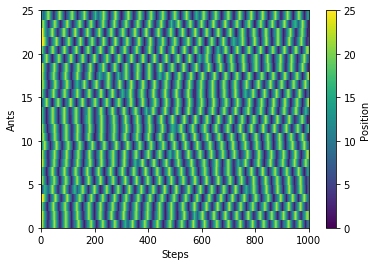

iter_data_run50_dplen10_ant25_dp100_pp100_fp95_step1K


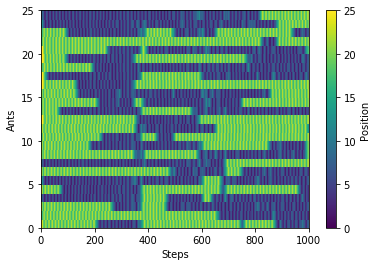

In [10]:
"""
ant movement in a single run
- with dp/pp at 0:
    - ants oscillate between nest/foraging zones
    - generalist (no division of labor, no leaf dropping)
- with dp/pp at 100:
    - ants stay in a particular zone for >100 time steps until flipping
    - task partitioned
"""

for title in title_list: 
    print(title)
    
    # load run data
    pop_data, ant_pos = pickle.load(open(title,'rb'))
    
    # plot spatial position of each ant on the grid as they move through time for a single run
    run = 0
    plt.pcolor(ant_pos[run])
    plt.xlabel('Steps')
    plt.ylabel('Ants')
    cbar = plt.colorbar()
    cbar.set_label('Position')
    plt.clim(0,h)
    plt.show()

In [11]:
def collective_population_plot(run_data, step_num, ant_num, max_score=0, save=0):
    """
    plots data outputs + zone counts of iterated model runs
    """
    # unpacks run data arrays
    [c_score,g_score,t_score,drops,nest_zone,forage_zone,tree_zone] = run_data
    
    # sets up plot with two y axes
    fig = plt.figure(figsize=(7,5))
    host = fig.add_subplot(111)
    par1 = host.twinx()

    # sets limits for x and left y axes
    host.set_xlim([0, step_num]) # time
    host.set_ylim([0, ant_num]) # concentration
    
    # sets right y axis to specified maximum or the rounded up nearest hundred if unspecified
    if max_score > 0:
        par1.set_ylim(0, max_score) # scores + drops
    else:
        output_max = max(drops[-1],t_score[-1])
        output_max_roundup = np.ceil(output_max/100)*100
        par1.set_ylim(0, output_max_roundup) # scores + drops
    
    # labels each axis
    host.set_xlabel("Steps")
    host.set_ylabel("Ants in Each Zone")
    par1.set_ylabel("Output (Drops or Score by Type)")

    # plots/labels each data array
    steps = range(step_num)
    p1, = host.plot(steps, tree_zone, color='seagreen', label='Tree Area')
    p2, = host.plot(steps, forage_zone, color='tomato', label='Foraging Area')
    p3, = host.plot(steps, nest_zone, color='cornflowerblue', label='Nest Area')
    p4, = par1.plot(steps, c_score, 
                   color='cornflowerblue', linestyle='--', label="Collector Output")
    p5, = par1.plot(steps, drops, 
                   color='tomato', linestyle='--', label="Dropper Output")
    p6, = par1.plot(steps, g_score, 
                   color='seagreen', linestyle='--', label="Generalist Output")
    p7, = par1.plot(steps, t_score, 
                   color='black', linestyle=':', label="Total Output")
    
    # adds legend
    lns = [p2, p1, p3, p4, p5, p6, p7]
    host.legend(handles=lns, loc='upper center')
    
    if save == 0:
        plt.show()
    else:
        plt.savefig(save,dpi=400)
        plt.show()
    
    # averages each zone count between the middle/end to represent steady state levels + prints results
    ss_run_num = int(step_num/2)
    ss_forg = np.average(forage_zone[ss_run_num:step_num])
    ss_tree = np.average(tree_zone[ss_run_num:step_num])
    ss_nest = np.average(nest_zone[ss_run_num:step_num])
    
    print(f'steady state from {ss_run_num} to {step_num} steps')
    print(f'ss forg: {round(ss_forg,1)}')
    print(f'ss tree: {round(ss_tree,1)}')
    print(f'ss nest: {round(ss_nest,1)}')
    print(f'ss (forage-nest) gap: {round(ss_forg - ss_nest,1)}')

iter_data_run50_dplen10_ant25_dp0_pp0_fp95_step1K


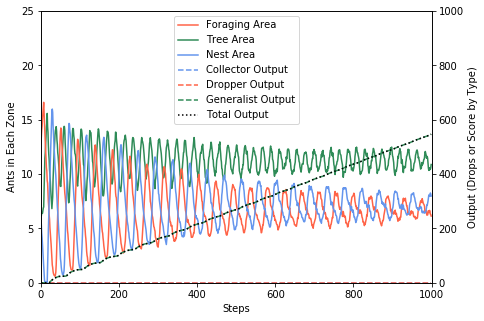

steady state from 500 to 1000 steps
ss forg: 6.6
ss tree: 11.2
ss nest: 7.2
ss (forage-nest) gap: -0.5

iter_data_run50_dplen10_ant25_dp100_pp100_fp95_step1K


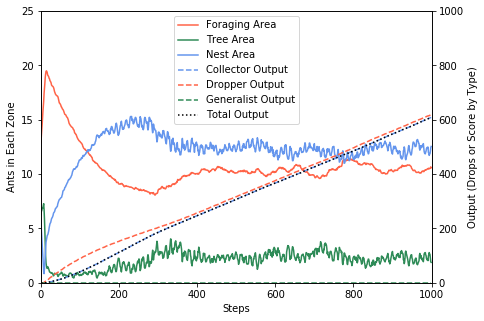

steady state from 500 to 1000 steps
ss forg: 10.4
ss tree: 2.4
ss nest: 12.2
ss (forage-nest) gap: -1.8



In [12]:
"""
collective ant behavior averaged across 50 runs
- with dp/pp at 0 (generalist):
    - ant populations oscillate between nest/foraging zones, starting from all walking up to forage
    - oscillations decrease with time as movement stochasticity walking up the tree averages out
    - steady state population levels between nest/forage roughly equal
    - ss population levels greater for tree than for nest/forage
- with dp/pp at 100 (task partitioned):
    - ants concentrate in foraging zone in the 100 steps, flattening out by 200 steps
    - ss population levels in nest about 2 ants greater than in foraging zone
    - ss population levels lower for tree than for nest/forage
    - foraging zone population average flatter than nest/tree 
    due to absence of tree-foraging zone fluctuations
    - total score greater for the task partitioned strategy than generalist
"""

# plotting parameters
max_cost = 0.3
max_score = 1000
run_count = 50

for (dp,pp),title in zip(input_list,title_list):
    print(title)
    
    # loads iterated model run data
    pop_data, ant_pos = pickle.load(open(title,'rb'))
    
    # calculate pickup cost applied to ant scores
    pp_cost = pp/100 * max_cost
    
    # average run data arrays for specified number of runs
    pop_data_mean = [np.mean(data_array[:run_count,:],axis=0) for data_array in pop_data]
    
    # apply pickup cost to ant scores (first three arrays of run data list)
    for i in range(4):
        pop_data_mean[i] = pop_data_mean[i]*(1 - pp_cost)
    
    collective_population_plot(pop_data_mean, step_num, ant_num, max_score=max_score)
    print()

run_count:  1


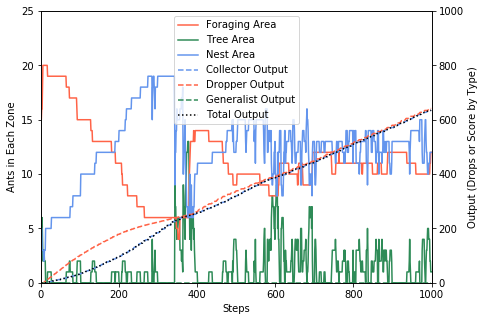

steady state from 500 to 1000 steps
ss forg: 10.5
ss tree: 1.7
ss nest: 12.8
ss (forage-nest) gap: -2.3

run_count:  5


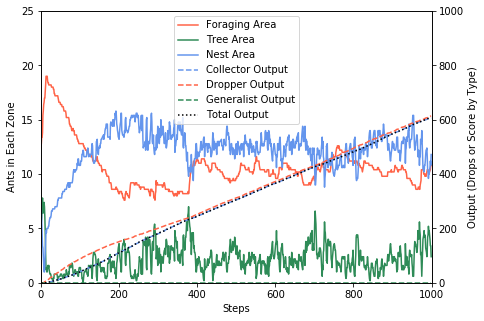

steady state from 500 to 1000 steps
ss forg: 10.4
ss tree: 2.3
ss nest: 12.3
ss (forage-nest) gap: -1.9

run_count:  10


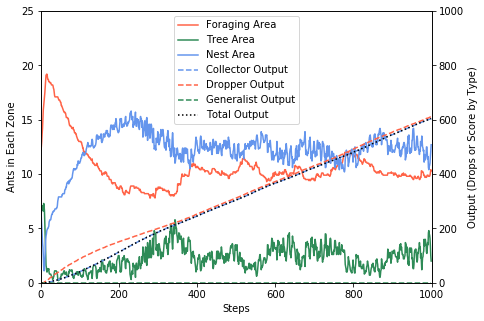

steady state from 500 to 1000 steps
ss forg: 10.3
ss tree: 2.4
ss nest: 12.2
ss (forage-nest) gap: -1.9

run_count:  25


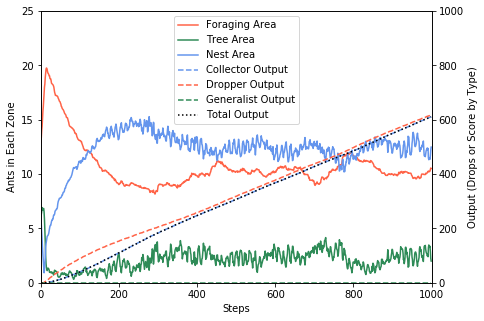

steady state from 500 to 1000 steps
ss forg: 10.3
ss tree: 2.4
ss nest: 12.3
ss (forage-nest) gap: -2.0

run_count:  50


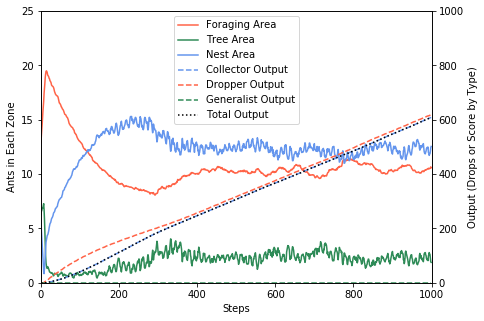

steady state from 500 to 1000 steps
ss forg: 10.4
ss tree: 2.4
ss nest: 12.2
ss (forage-nest) gap: -1.8



In [13]:
"""
collective ant behavior averaged across a variable number of runs
- run count = 1: step changes in population levels between time steps
- run count = 50: variability drastically reduced, inherent stochasticity remains
"""

max_cost = 0.3
max_score = 1000
run_count = 50

pp = 100
title = 'iter_data_run50_dplen10_ant25_dp100_pp100_fp95_step1K'

for run_count in [1,5,10,25,50]:
    print(f'run_count: ',run_count)
    
    pop_data, ant_pos = pickle.load(open(title,'rb')) 
    pp_cost = pp/100 * max_cost
    pop_data_mean = [np.mean(data_array[:run_count,:],axis=0) for data_array in pop_data]
    for i in range(4):
        pop_data_mean[i] = pop_data_mean[i]*(1 - pp_cost)
    collective_population_plot(pop_data_mean, step_num, ant_num, max_score=max_score)
    print()

In [14]:
def collective_population_plot_control(run_data, step_num, ant_num, max_score=0, save=0):
    """
    plots data outputs + zone counts of iterated model runs
    """
    # unpacks run data arrays
    [c_score,g_score,t_score,drops,nest_zone,forage_zone,tree_zone] = run_data
    
    # sets up plot with two y axes
    fig = plt.figure(figsize=(7,5))
    host = fig.add_subplot(111)
    par1 = host.twinx()

    # sets limits for x and left y axes
    host.set_xlim(0, step_num) # time
    host.set_ylim(0, ant_num) # ant number
    
    # sets right y axis to specified maximum or the rounded up nearest ten if unspecified
    if max_score > 0:
        par1.set_ylim(0, max_score) # dropped leaves in cache
    else:
        output_max = max(drops-c_score)
        output_max_roundup = np.ceil(output_max/10)*10
        par1.set_ylim(0, output_max_roundup) # dropped leaves in cache

    # averages each zone count between the middle/end to represent steady state levels + prints results
    ss_run_num = int(step_num/2)
    ss_forg = np.average(forage_zone[ss_run_num:step_num])
    ss_tree = np.average(tree_zone[ss_run_num:step_num])
    ss_nest = np.average(nest_zone[ss_run_num:step_num])
    ss_cache = np.average(drops[ss_run_num:step_num] - c_score[ss_run_num:step_num])
    
    # labels each axis
    host.set_xlabel("Steps")
    host.set_ylabel("Ants in Each Zone")
    par1.set_ylabel("Dropped Leaves in Cache")

    # plots/labels each data array
    steps = range(step_num)
    p1, = host.plot(steps, tree_zone, color='seagreen', label='Tree Area')
    p2, = host.plot(steps, forage_zone, color='tomato', label='Foraging Area')
    p3, = host.plot(steps, nest_zone, color='cornflowerblue', label='Nest Area')
    p4, = par1.plot(steps, drops - c_score, 
                   color='black', linestyle='-', label="Dropped Leaves in Cache")
    
    p5, = host.plot(steps, np.ones(step_num)*ss_tree, 
                    color='seagreen', linestyle='--', label='Tree Area SS')
    p6, = host.plot(steps, np.ones(step_num)*ss_forg, 
                    color='tomato', linestyle='--', label='Foraging Area SS')
    p7, = host.plot(steps, np.ones(step_num)*ss_nest, 
                    color='cornflowerblue', linestyle='--', label='Nest Area SS')
    p8, = par1.plot(steps, np.ones(step_num)*ss_cache, 
                   color='k', linestyle='--', label="Dropped Leaves in Cache SS")
    
    # adds legend
    lns = [p2, p1, p3, p4]
    host.legend(handles=lns, loc='upper right')
    
    if save == 0:
        plt.show()
    else:
        plt.savefig(save,dpi=400)
        plt.show()
        
    print(f'steady state from {ss_run_num} to {step_num} steps')
    print(f'ss forg: {round(ss_forg,1)}')
    print(f'ss tree: {round(ss_tree,1)}')
    print(f'ss nest: {round(ss_nest,1)}')
    print(f'ss cache: {round(ss_cache,1)}')

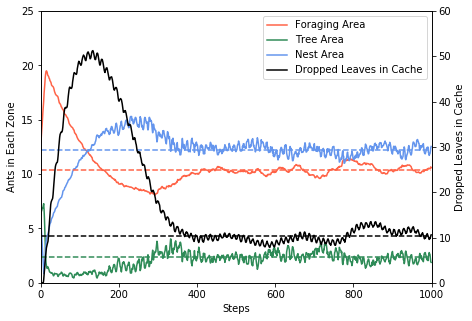

steady state from 500 to 1000 steps
ss forg: 10.4
ss tree: 2.4
ss nest: 12.2
ss cache: 10.4



In [15]:
"""
collective ant behavior averaged across 50 runs
plotted as control parameters, highlighting influence of dropped leaves in the cache

- with dp/pp at 0 (generalist):
    - 
- with dp/pp at 100 (task partitioned):
    - 
"""

# plotting parameters
max_cost = 0.3
max_score = 1000
run_count = 50

pp = 100
title = 'iter_data_run50_dplen10_ant25_dp100_pp100_fp95_step1K'

pop_data, ant_pos = pickle.load(open(title,'rb')) 
pp_cost = pp/100 * max_cost
pop_data_mean = [np.mean(data_array[:run_count,:],axis=0) for data_array in pop_data]
for i in range(4):
    pop_data_mean[i] = pop_data_mean[i]*(1 - pp_cost)
collective_population_plot_control(pop_data_mean, step_num, ant_num, max_score=0)
print()

# Run Iteration - Create Landscape

In [ ]:
"""
create fitness landscape with different combinations of drop/pickup probabilities
plots of resulting data shown in next jupyter notebook
"""

# data file will be saved as
file_name = 'landscape_data_dplen10_ant25_spacing5_rep10_step1K'

# set colony parameters
dplen = 10 # drop length, e.g. 1, 10, 20, 40
ant_num = 25 # ants per colony
fp = 95 # foraging probability kept constant
vis = 5 # vision range kept constant

# set grid parameters
h = dplen + vis*2 + 5
w = 11

# set iteration parameters
spacing = 5  # test every X trait values
run_num = 10 # simulation runs per trait combination
step_num = 1000 # model steps per run

landscape_data = []
for dp in list(range(0,101,spacing)):
    for pp in list(range(0,101,spacing)):
        # iterate model run + collect data
        iter_data, ant_pos = data_coll_iter(dplen, w, ant_num, dp, pp, fp, vis, step_num, run_num, buffer=0)
        # unpack data types
        c_score, g_score, t_score, drops, nest_zone, forage_zone, tree_zone = iter_data
        # save averaged data as a tuple for each trait combination
        landscape_data.append(
            (dp, pp, np.average(c_score,axis=0), np.average(g_score,axis=0), 
             np.average(t_score,axis=0), np.average(drops,axis=0), 
             np.average(nest_zone,axis=0), np.average(forage_zone,axis=0), 
             np.average(tree_zone,axis=0))
        )
        # serialize data to file
        pickle.dump(landscape_data,open(file_name,'wb'))